In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_man = pd.read_csv('/content/drive/Shareddrives/2022-2 KUBIG 추천시스템/2팀/새로운시작/무신사 코디맵 크롤링한 데이터/all_man_pulsnaver.csv')
df_woman = pd.read_csv('/content/drive/Shareddrives/2022-2 KUBIG 추천시스템/2팀/새로운시작/무신사 코디맵 크롤링한 데이터/all_woman_pulsnaver.csv')

In [ ]:
df_man_img = df_man[['title','prd_title','prd_img','category','category_naver','prd_title_naver']]
df_woman_img = df_woman[['title','prd_title','prd_img','category','category_naver','prd_title_naver']]

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image

In [ ]:
class FeatureExtractor:
  def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

  def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = img
        x = np.expand_dims(x, axis=0) #차원추가
        x = preprocess_input(x) #모델에 필요한 형식에 이미지를 적절하게 맞추기위한 것
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

In [ ]:
images_m = [0 for i in range(len(df_man_img))]
features_m_vgg = [0 for i in range(len(df_man_img))]

man_drop = [39,55,244,245,246,285,307,309,310,311,312,314,315,316,317,318,319,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,340,341,342,343,344,345,346,347,348,349,350,351,353,354,355,356,357,358,359,360,362,363,364,365,366,414,418,421]
fe = FeatureExtractor()

for i in range(len(df_man_img)):
  if i in man_drop:
    continue
  img = Image.open(f"/content/drive/MyDrive/추천시스템/남성/man_{i}.jpg")
  fea = fe.extract(img)
  features_m_vgg[i] = fea
  images_m[i] = img

1/1 [==============================] - 1s 556ms/step


In [ ]:
images_w = [0 for i in range(len(df_woman_img))]
features_w_vgg = [0 for i in range(len(df_woman_img))]

woman_drop = [47,77,134,139,148,149,157,171,220,273,313,314,315,319,321,329,342,352,353,356,357,397,404,413,415,424,427,447,461,477,479,504,510,513,527,529,530,537,541,542,544,545,547,548,549,550,551,553,554,555,557,558,559,560,561,563,565,566,569,570,573,574,575,576,578,579,582,583,584,585,587,588,589,590,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,609,610,611,612,613,614,615,616,617,618,620,621,622,623,624,625,626,628,629,631,632,637,638,639,644,645,647,648,649,651,652,653,654,658,659]
fe = FeatureExtractor()

for i in range(len(df_woman_img)):
  if i in woman_drop:
    continue
  img = Image.open(f"/content/drive/MyDrive/추천시스템/이미지/무신사/여성/woman_{i}.jpg")
  fea = fe.extract(img)
  features_w_vgg[i] = fea
  images_w[i] = img

1/1 [==============================] - 1s 534ms/step


In [ ]:
df_woman_img['feature_vgg'] = features_w_vgg
df_man_img['feature_vgg'] = features_m_vgg

<ipython-input-9-8beb9efb23a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_woman_img['feature_vgg'] = features_w_vgg
<ipython-input-9-8beb9efb23a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_man_img['feature_vgg'] = features_m_vgg


In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

# Image transforms
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    img = img.convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros([1, 512, 1, 512])
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
def cos_pytorch(A, B):
  cos= nn.CosineSimilarity(dim=1, eps=1e-6)
  cos_sim = cos(A, B)
  return cos_sim.numpy()[0][0][0]

In [ ]:
features_m_resnet = [0 for i in range(len(df_man_img))]
for i in range(len(df_man_img)):
  if i in man_drop:
    continue
  fea = get_vector(f"/content/drive/MyDrive/추천시스템/남성/man_{i}.jpg")
  features_m_resnet[i] = fea

In [ ]:
features_w_resnet = [0 for i in range(len(df_woman_img))]
for i in range(len(df_woman_img)):
  if i in woman_drop:
    continue
  fea = get_vector(f"/content/drive/MyDrive/추천시스템/이미지/무신사/여성/woman_{i}.jpg")
  features_w_resnet[i] = fea

In [ ]:
df_man_img['feature_resnet'] = features_m_resnet

<ipython-input-15-9bff6326608c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_man_img['feature_resnet'] = features_m_resnet


In [ ]:
df_woman_img['feature_resnet'] = features_w_resnet

<ipython-input-16-47e409900367>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_woman_img['feature_resnet'] = features_w_resnet


유클리디안 거리 기반 추천

In [ ]:
images_m_resize = [0 for i in range(len(images_m))]

for i in range(len(images_m)):
  if i in man_drop:
    continue
  images_m_resize[i] = images_m[i].resize((224, 224)).convert('RGB')

In [ ]:
images_m_array = [np.array(i) for i in images_m_resize]

In [ ]:
dist = []
for i in range(len(images_m_array)):
  if i in man_drop:
    continue
  dis= np.linalg.norm(images_m_array[0] - images_m_array[i]) #0번째 사진에 대한 추천
  dist.append((dis,i))

In [ ]:
c = sorted(dist)[1:6] # 상위 9개만 선택

In [ ]:
print(c) #거리와 유사 아이템 인덱스

[(29729.094469895983, 32), (29772.157546943083, 140), (30839.96656937228, 40), (31800.072955891155, 47), (31861.865011326627, 268)]


In [ ]:
index = [c[i][1] for i in range(len(c))]

IndexError: ignored

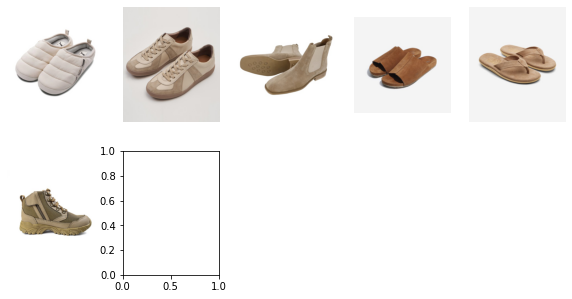

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize = (10,5))

plt.subplot(2,5,1)
plt.imshow(images_m[0])
plt.axis('off')

for i in range(9):
  plt.subplot(2,5,i+2)
  plt.imshow(images_m[index[i]])
  plt.axis('off')

In [ ]:
images_w_resize = [0 for i in range(len(images_w))]

for i in range(len(images_w)):
  if i in woman_drop:
    continue
  images_w_resize[i] = images_w[i].resize((224, 224)).convert('RGB')

In [ ]:
images_w_array = [np.array(i) for i in images_w_resize]

In [ ]:
dist = []
for i in range(len(images_w_array)):
  if i in woman_drop:
    continue
  dis= np.linalg.norm(images_w_array[0] - images_w_array[i]) #0번째 사진에 대한 추천
  dist.append((dis,i))

In [ ]:
c = sorted(dist)[1:6] # 상위 9개만 선택

In [ ]:
print(c) #거리와 유사 아이템 인덱스

[(22892.483591781824, 159), (22998.66835275469, 204), (22998.66835275469, 221), (23011.967625563877, 237), (23074.436916206643, 494)]


In [ ]:
index = [c[i][1] for i in range(len(c))]

IndexError: ignored

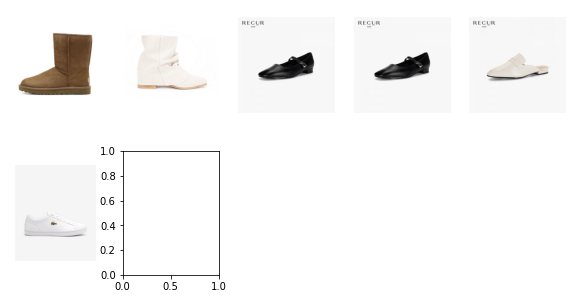

In [ ]:
#추천 결과
from matplotlib import pyplot as plt

plt.figure(figsize = (10,5))

plt.subplot(2,5,1)
plt.imshow(images_w[0])
plt.axis('off')

for i in range(9):
  plt.subplot(2,5,i+2)
  plt.imshow(images_w[index[i]])
  plt.axis('off')

VGG16으로 추출한 feature vector 간 cosine similarity 기반 추천

In [ ]:
cos_dist = []
for i in range(len(df_man_img['feature_vgg'])):
  if i in man_drop:
    continue
  dist= cos(df_man_img['feature_vgg'][0],df_man_img['feature_vgg'][i])
  cos_dist.append((dist,i))

In [ ]:
b = sorted(cos_dist, reverse=True)[:9]

In [ ]:
sim = [b[i][0] for i in range(len(b))]
print(sim)

[1.0, 0.7035721, 0.6829524, 0.6829524, 0.6770032, 0.6760648, 0.67553306, 0.6745033, 0.67385864]


In [ ]:
print(b) #resnet

[(1.0, 0), (0.7035721, 97), (0.6829524, 383), (0.6829524, 372), (0.6770032, 35), (0.6760648, 108), (0.67553306, 106), (0.6745033, 47), (0.67385864, 17)]


In [ ]:
index = [b[i][1] for i in range(len(b))]

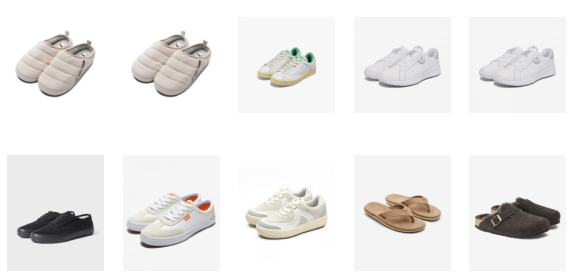

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize = (10,5))

plt.subplot(2,5,1)
plt.imshow(images_m[0])
plt.axis('off')

for i in range(9):
  plt.subplot(2,5,i+2)
  plt.imshow(images_m[index[i]])
  plt.axis('off')

In [ ]:
cos_dist = []
for i in range(len(df_woman_img['feature_vgg'])):
  if i in woman_drop:
    continue
  dist= cos(df_woman_img['feature_vgg'][0],df_woman_img['feature_vgg'][i])
  cos_dist.append((dist,i))

In [ ]:
b = sorted(cos_dist, reverse=True)[:9]

In [ ]:
sim = [b[i][0] for i in range(len(b))]
print(sim)

[1.0, 0.8281858, 0.8065081, 0.77751416, 0.75171864, 0.744338, 0.7178459, 0.6914777, 0.6818054]


In [ ]:
print(b) #resnet

[(1.0, 0), (0.8281858, 86), (0.8065081, 260), (0.77751416, 60), (0.75171864, 57), (0.744338, 54), (0.7178459, 68), (0.6914777, 340), (0.6818054, 301)]


In [ ]:
index = [b[i][1] for i in range(len(b))]

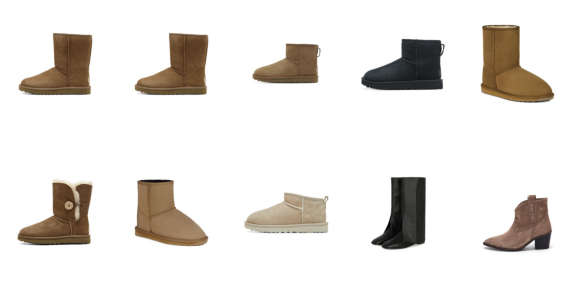

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize = (10,5))

plt.subplot(2,5,1)
plt.imshow(images_w[0])
plt.axis('off')

for i in range(9):
  plt.subplot(2,5,i+2)
  plt.imshow(images_w[index[i]])
  plt.axis('off')

Resnet18로 추출한 feature vector 간 cosine similarity 기반 추천

In [ ]:
df_man['shoes_to_shoes'] = [[] for i in range(len(df_man))]

In [ ]:
for i in range(len(df_man_img['feature_resnet'])):
  if i in man_drop:
    continue

  cos_dist1 = []
  for j in range(len(df_man_img['feature_resnet'])):
    if j in man_drop:
      continue
    dist= cos_pytorch(df_man_img['feature_resnet'][i],df_man_img['feature_resnet'][j])
    cos_dist1.append((dist,j))
  a = sorted(cos_dist1, reverse=True)[1:6]
  
  df_man['shoes_to_shoes'][i] = ['man_' + str(a[0][1]) + '.jpg',
                                 'man_' + str(a[1][1]) + '.jpg',
                                 'man_' + str(a[2][1]) + '.jpg',
                                 'man_' + str(a[3][1]) + '.jpg',
                                 'man_' + str(a[4][1]) + '.jpg',]

<ipython-input-47-a260e0ebb0a6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_man['shoes_to_shoes'][i] = ['man_' + str(a[0][1]) + '.jpg',


In [ ]:
df_man['shoes_to_shoes']

0      [man_49.jpg, man_45.jpg, man_57.jpg, man_241.j...
1      [man_18.jpg, man_12.jpg, man_1.jpg, man_43.jpg...
2      [man_130.jpg, man_224.jpg, man_127.jpg, man_22...
3      [man_205.jpg, man_352.jpg, man_4.jpg, man_126....
4      [man_22.jpg, man_48.jpg, man_231.jpg, man_192....
                             ...                        
422    [man_417.jpg, man_401.jpg, man_392.jpg, man_38...
423    [man_398.jpg, man_412.jpg, man_406.jpg, man_38...
424    [man_374.jpg, man_367.jpg, man_411.jpg, man_25...
425    [man_387.jpg, man_382.jpg, man_291.jpg, man_38...
426    [man_420.jpg, man_415.jpg, man_368.jpg, man_40...
Name: shoes_to_shoes, Length: 427, dtype: object

In [ ]:
# cos_dist11[2]

In [ ]:
# a = sorted(cos_dist1, reverse=True)[:9]

In [ ]:
print(a)

In [ ]:
index = [a[i][1] for i in range(len(a))]

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize = (10,5))

plt.subplot(2,5,1)
plt.imshow(images_w[0])
plt.axis('off')

for i in range(9):
  plt.subplot(2,5,i+2)
  plt.imshow(images_w[index[i]])
  plt.axis('off')

여성

In [ ]:
df_woman['shoes_to_shoes'] = [[] for i in range(len(df_woman))]

In [ ]:
for i in range(len(df_woman_img['feature_resnet'])):
  if i in woman_drop:
    continue

  cost_dist1 = []
  for j in range(len(df_woman_img['feature_resnet'])):
    if j in woman_drop:
      continue
    dist= cos_pytorch(df_woman_img['feature_resnet'][i],df_woman_img['feature_resnet'][j])
    cos_dist1.append((dist,j))
  a = sorted(cos_dist1, reverse=True)[1:6]
  
  df_woman['shoes_to_shoes'][i] = ['woman_' + str(a[0][1]) + '.jpg',
                                 'woman_' + str(a[1][1]) + '.jpg',
                                 'woman_' + str(a[2][1]) + '.jpg',
                                 'woman_' + str(a[3][1]) + '.jpg',
                                 'woman_' + str(a[4][1]) + '.jpg',]

<ipython-input-51-7c13576d623b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_woman['shoes_to_shoes'][i] = ['woman_' + str(a[0][1]) + '.jpg',


In [ ]:
df_woman['shoes_to_shoes']

0      [woman_420.jpg, woman_415.jpg, woman_0.jpg, wo...
1      [woman_420.jpg, woman_415.jpg, woman_1.jpg, wo...
2      [woman_420.jpg, woman_415.jpg, woman_1.jpg, wo...
3      [woman_420.jpg, woman_415.jpg, woman_59.jpg, w...
4      [woman_420.jpg, woman_415.jpg, woman_59.jpg, w...
                             ...                        
655    [woman_364.jpg, woman_341.jpg, woman_266.jpg, ...
656    [woman_364.jpg, woman_341.jpg, woman_266.jpg, ...
657    [woman_364.jpg, woman_341.jpg, woman_266.jpg, ...
658                                                   []
659                                                   []
Name: shoes_to_shoes, Length: 660, dtype: object

csv 저장

In [ ]:
df_man.to_csv("/content/drive/MyDrive/추천시스템/all_man_pulsnaver_plusshoestoshoes.csv",index=False)

In [ ]:
df_woman.to_csv("/content/drive/MyDrive/추천시스템/all_woman_pulsnaver_plusshoestoshoes.csv",index=False)

제윤이 데이터랑 concat하기

In [ ]:
man1 = pd.read_csv('/content/drive/Shareddrives/2022-2 KUBIG 추천시스템/2팀/새로운시작/무신사 코디맵 크롤링한 데이터/all_man_pulsnaver_pluscoditocodi.csv',index_col=0)
woman1 = pd.read_csv('/content/drive/Shareddrives/2022-2 KUBIG 추천시스템/2팀/새로운시작/무신사 코디맵 크롤링한 데이터/all_woman_pulsnaver_pluscoditocodi.csv', index_col = 0)

In [ ]:
man2 = pd.read_csv('/content/drive/MyDrive/추천시스템/all_man_pulsnaver_plusshoestoshoes.csv',index_col=0)
woman2 = pd.read_csv('/content/drive/MyDrive/추천시스템/all_woman_pulsnaver_plusshoestoshoes.csv', index_col = 0)

In [ ]:
man = pd.concat([man1, man2['shoes_to_shoes']], axis=1)
woman = pd.concat([woman1, woman2['shoes_to_shoes']], axis=1)

In [ ]:
man.to_csv("/content/drive/MyDrive/추천시스템/all_man_pulsnaver_pluscodishoes.csv", index=False)
woman.to_csv("/content/drive/MyDrive/추천시스템/all_woman_pulsnaver_pluscodishoes.csv", index=False)

In [ ]:
man.to_csv("/content/drive/Shareddrives/2022-2 KUBIG 추천시스템/2팀/새로운시작/무신사 코디맵 크롤링한 데이터/all_man_pulsnaver_pluscodishoes.csv", index=False)
woman.to_csv("/content/drive/Shareddrives/2022-2 KUBIG 추천시스템/2팀/새로운시작/무신사 코디맵 크롤링한 데이터/all_woman_pulsnaver_pluscodishoes.csv", index=False)

Resnet19fh로 추출한 feature vector 간 유클리디안 거리 기반 추천

In [ ]:
# dist = []
# for i in range(len(df_woman_img['feature_resnet'])):
#   dis= np.linalg.norm(df_woman_img['feature_resnet'][0]-df_woman_img['feature_resnet'][i])
#   dist.append((dis,i))

In [ ]:
# d = sorted(dist)[:9]

In [ ]:
# print(d)

In [ ]:
# index = [a[i][1] for i in range(len(a))]

In [ ]:
# from matplotlib import pyplot as plt

# plt.figure(figsize = (10,5))

# plt.subplot(2,5,1)
# plt.imshow(images_w[0])
# plt.axis('off')

# for i in range(9):
#   plt.subplot(2,5,i+2)
#   plt.imshow(images_w[index[i]])
#   plt.axis('off')